# Deep Learning with PyTorch Step-by-Step: A Beginner's Guide

# Chapter 7

In [1]:
from config import *

# This is needed to render the plots in this chapter
from plots.chapter7 import *

In [2]:
import numpy as np
from PIL import Image

import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import DataLoader, Dataset, random_split, TensorDataset
from torchvision.transforms import Compose, ToTensor, Normalize, Resize, ToPILImage, CenterCrop, RandomResizedCrop
from torchvision.datasets import ImageFolder
from torchvision.models import alexnet, resnet18, inception_v3
from torchvision.models.alexnet import model_urls
try:
    from torchvision.models.utils import load_state_dict_from_url
except ImportError:
    from torch.hub import load_state_dict_from_url

from stepbystep.v3 import StepByStep
from data_generation.rps import download_rps

# Transfer learning.

The idea is quite simple: first, some big tech company, which has access to virtually
infinite amounts of data and computing power, develops and trains a huge model
for their own purpose. Next, once it is trained, its architecture and the
corresponding trained weights (the pre-trained model) are released. Finally,
everyone else can use these weights as a starting point and fine-tune it further for
a different (but similar) purpose.

That’s **transfer learning** in a nutshell. It started with computer vision models and…

## ImageNet

>ImageNet is an image database organized according to the WordNet[104] hierarchy (currently only the nouns), in which each node of the hierarchy is depicted by hundreds and thousands of images. Currently we have an average of over five hundred images per node. We hope ImageNet will become a useful resource for researchers, educators, students and all of you who share our passion for pictures.
Source: ImageNet[105]

ImageNet is a comprehensive database of images spanning 27 high-level
categories, more than 20,000 sub-categories, and more than 14 million images
(check its statistics here[106]). The images themselves cannot be downloaded from its website because ImageNet does not own the copyright of these images. It does
provide the URLs for all images, though.

As you can probably guess, classifying these images was a monumental task in the
early 2010s. No wonder they created a challenge…

# ImageNet Large Scale Visual Recognition Challenge (ILSVRC)

> The ImageNet Large Scale Visual Recognition Challenge (ILSVRC) evaluates
algorithms for object detection and image classification at large scale.
Source: ILSVRC[107]

The ILSVRC ran for eight years, from 2010 to 2017. Many architectures we take
for granted today were developed to tackle this challenge: AlexNet, VGG,
Inception, ResNet, and more. We’re focusing on the years of 2012, 2014, and 2015
only.

#### ILSVRC-2012

The 2012 edition[108] of the ILSVRC is probably the most popular of them all. Its
winner, the architecture dubbed **AlexNet**, represented a milestone for image
classification, sharply reducing the classification error. The training data had 1.2
million images belonging to 1,000 categories (it is actually a subset of the ImageNet
dataset).

#### AlexNet (SuperVision Team)

The architecture was developed by the SuperVision team, composed of Alex
Krizhevsky, Ilya Sutskever, and Geoffrey Hinton from the University of Toronto
(now you know why it’s called AlexNet). Here is their model’s description:

> Our model is a large, deep convolutional neural network trained on raw RGB
pixel values. The neural network, which has 60 million parameters and
650,000 neurons, consists of five convolutional layers, some of which are
followed by max-pooling layers, and three globally-connected layers with a
final 1000-way softmax. It was trained on two NVIDIA GPUs for about a
week. To make training faster, we used **non-saturating neurons** and a very
efficient GPU implementation of convolutional nets. To reduce overfitting in
the globally-connected layers we employed hidden-unit **dropout"**, a
recently-developed regularization method that proved to be very effective.
Source: Results (ILSVRC2012)[109]

You should be able to recognize all the elements in the description: five typical
convolutional blocks (convolution, activation function, and max-pooling)
corresponding to the "featurizer" part of the model, three hidden (linear) layers
combined with dropout layers corresponding to the "classifier" part of the model,
and the softmax output layer typical of multiclass classification problems.

It is pretty much the **fancier model from Chapter 6 but on steroids**! We’ll be using
AlexNet to demonstrate how to use a pre-trained model. In case you’re interested
to learn more about AlexNet, their paper is called "ImageNet Classification with Deep
Convolutional Neural Networks"[110].


#### ILSVRC-2014

The 2014 edition[111] gave rise to two common household names when it comes to
architectures for computer vision problems: VGG and Inception. The training data
had 1.2 million images belonging to 1,000 categories, just like the 2012 edition.

**VGG**
The architecture developed by Karen Simonyan and Andrew Zisserman from the
Oxford Vision Geometry Group (VGG) is pretty much an even larger or, better yet,
deeper model than AlexNet (and now you know the origin of yet another
architecture name). Their goal is crystal clear in their model’s description:

> …we explore the effect of the convolutional network (ConvNet) depth on its
accuracy.
Source: Results (ILSVRC2014)[112]

VGG models are massive, so we’re not paying much attention to them here. If you
want to learn more about it, its paper is called "Very Deep Convolutional Networks for
Large-Scale Image Recognition"[113].


#### Inception (GoogLeNet Team)

The Inception architecture is probably the one with the best meme of all: *"We need
to go deeper"*. The authors, Christian Szegedy, et al., like the VGG team, also wanted
to train a deeper model. But they came up with a clever way of doing it (highlights
are mine):

> Additional **dimension reduction layers** based on embedding learning
intuition allow us to **increase both the depth and the width of the network**
significantly without incurring significant computational overhead.
Source: Results (ILSVRC2014)[114]

If you want to learn more about it, the paper is called "Going Deeper with
Convolutions"[115].

> "What are these **dimension reduction layers?**"

No worries, we’ll get back to it in the "Inception Modules" section.


#### ILSVRC-2015

The 2015 edition[116] popularized residual connections in the aptly named
architecture: Res(idual) Net(work). The training data used in the competition
remained unchanged.

**ResNet (MSRA Team)**

The trick developed by Kaiming He, et al. was to add residual connections, or
shortcuts, to a very deep architecture.

>We train neural networks with depth of over 150 layers. We propose a "deep
residual learning" framework that eases the optimization and convergence of
extremely deep networks.
Source: Results (ILSVRC2015)[117]

In a nutshell, it allows the network to more easily learn the identity function. We’ll
also get back to it in the "Residual Connections" section later in this chapter. If you
want to learn more about it, the paper is called "Deep Residual Learning for Image
Recognition"[118].

> By the way, Kaiming He also has an initialization scheme named
after him - sometimes referred to as "He initialization", sometimes
referred to as "Kaiming initialization" - and we’ll learn about those
later in the next chapter.


## Comparing Architectures

Let’s compare their performances (Top-1 accuracy %), number of operations in a single forward pass (billions), and sizes (in millions of parameters). The figure below is very illustrative in this sense:

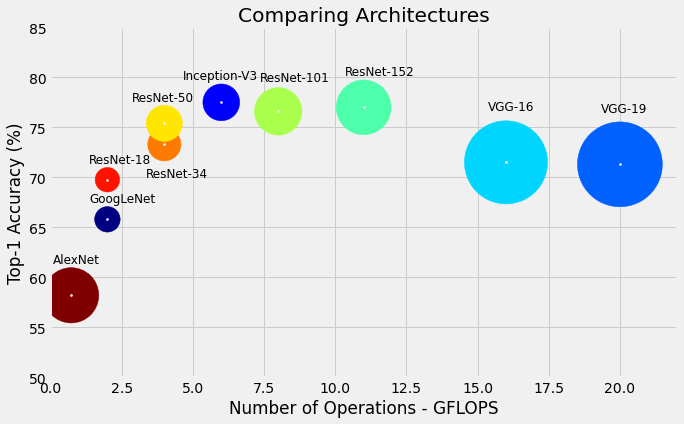

In [3]:
fig = figure1()

*Source: Data for accuracy and GFLOPs estimates obtained from [this](https://github.com/albanie/convnet-burden) report, number of parameters proportional to the size of the circles) obtained from Torchvision’s models. For a more detailed analysis, see Canziani, A., Culurciello, E., Paszke, A. ["An Analysis of Deep Neural Network Models for Practical Applications"](https://arxiv.org/pdf/1605.07678.pdf)(2017).*

See how massive the VGG models are, both in size and in the number of operations
required to deliver a single prediction? On the other hand, check Inception-V3 and
ResNet-50's positions in the plot: they would give more bang for your buck. **The
former has a slightly higher performance, and the latter is slightly faster**.

> These are the models you’re likely using for transfer learning:
**Inception** and **ResNet**.

On the bottom left, there is AlexNet. It was miles ahead of anything else in 2012,
but it is not competitive at all anymore

> "If AlexNet is not competitive, why are you using it to illustrate
transfer learning?"

A fair point indeed. The reason is, its architectural elements are already familiar to
you, thus making it easier for me to explain how we’re modifying it to fit our
purposes.

# Transfer Learning in Practice

We'll use Rock Paper Scissors Dataset.

It all starts with **loading a pre-trained model**, which can be easily done using
`Torchvision`’s library of models. There, we find AlexNet, a PyTorch model that
implements the architecture designed by Alex Krizhevsky et al, and alexnet, a
helper method that creates an instance of AlexNet and, optionally, downloads and
loads its pre-trained weights.

## Pre-Trained Model

We’ll start by creating an instance of AlexNet without loading its pre-trained
weights just yet:

In [4]:
alex = alexnet(pretrained=False)
print(alex)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

AlexNet’s architecture has three main elements: `features`, `avgpool`, and
`classifier`. The first and last are nested sequential models. The featurizer contains
five typical convolutional blocks, and the classifier has two hidden layers using 50%
dropout. You’re already familiar with all of this, except for the element in the
middle.

### Adaptive Pooling

The element in the middle, `AdaptiveAvgPool2d` (`F.adaptive_avg_pool2d` in its
functional form), is a **special kind of pooling**: instead of requiring the kernel size
(and stride), **it requires the desired output size**. In other words, whatever the
image size it gets as input, it will return a tensor with the desired size.

> "What’s so special about this?"

It gives you the **freedom to use images of different sizes as inputs**! We’ve seen that
convolutions and traditional max-pooling, in general, shrink the image’s dimensions.
But the classifier part of the model expects an input of a determined size. That
meant that the input image had to be of a determined size such that, at the end of
the shrinkage process, it matched what the classifier part was expecting. **The
adaptive pooling guarantees the output size, so it can easily match the classifier
expectations regarding input size.**

Let’s say we have two dummy tensors representing feature maps produced by the
"featurizer part of the model. The feature maps have different dimensions (32x32
and 12x12). Applying adaptive pooling to both of them ensures that both outputs
have the same dimensions (6x6):

In [5]:
result1 = F.adaptive_avg_pool2d(torch.randn(16, 32, 32), output_size=(6, 6))
result2 = F.adaptive_avg_pool2d(torch.randn(16, 12, 12), output_size=(6, 6))
result1.shape, result2.shape

(torch.Size([16, 6, 6]), torch.Size([16, 6, 6]))

### Loading Weights

First things first: to load the weights into our model, we need to retrieve them.
Sure, an easy way of retrieving them would be to set the argument
pretrained=True while creating the model. But you can also download the weights
from a given URL, which gives you the flexibility to use pre-trained weights from
wherever you want!

PyTorch offers the `load_state_dict_from_url` method: it will retrieve the weights
from the specified URL and, optionally, save them to a specified folder (`model_dir`
argument).

> "Great, but what’s the URL for AlexNet’s weights?"

You can get the URL from the model_urls variable in `torchvision.models.alexnet`:

In [6]:
url = model_urls['alexnet']
url

'https://download.pytorch.org/models/alexnet-owt-7be5be79.pth'

Of course, it doesn’t make any sense to do this manually for models in PyTorch’s
library. But, assuming you’re using pre-trained weights from a third-party, you’d be
able to load them like this:

In [7]:
state_dict = load_state_dict_from_url(url, model_dir='./pretrained', progress=True)

From now on, it works as if we had saved a model to disk. To load the model’s state
dictionary, we can use its load_state_dict method:

In [8]:
alex.load_state_dict(state_dict)

<All keys matched successfully>

### Model Freezing

In most cases, **you don’t want to continue training the whole model**. I mean, in
theory, you could pick it up where it was left off by the original authors, and resume
training using your own dataset. That’s a lot of work, and you’d need a lot of data to
make any kind of meaningful progress. There must be a better way! Of course,
there is: we can freeze the model.

> Freezing the model means it won’t learn anymore, that is, its
parameters/weights will not be updated anymore.

What best characterizes a tensor representing a **learnable parameter**? It requires
gradients. So, if we’d like to make them stop learning anything, we need to change
exactly that:

In [9]:
def freeze_model(model):
    for parameter in model.parameters():
        parameter.requires_grad = False

In [10]:
freeze_model(alex)

The function above loops over all parameters of a given model and freezes them.

> "If the model is frozen, how I am supposed to train it for my own
purpose?"

Excellent question! **We have to unfreeze a small part of the model or, better yet,
replace a small part of the model**. We’ll be replacing the…

### Top of the Model

The "top" of the model is loosely defined as the last layer(s) of the model, usually
belonging to its classifier part. The **"featurizer"** part is usually left untouched since
we’re trying to leverage the model’s ability to generate features for us. Let’s
inspect AlexNet’s classifier once again:

In [11]:
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Linear(in_features=4096, out_features=1000, bias=True)
)


It has **two hidden layers and one output layer**. The output layer produces 1,000
logits, one for each class in the ILSVRC challenge. But, unless you are playing with
the dataset used for the challenge, you’d have your own classes to compute logits
for.

In our "Rock, Paper, Scissors" dataset, we have **three classes**. So, we need to replace
**the output layer accordingly**:

In [12]:
torch.manual_seed(11)
alex.classifier[6] = nn.Linear(4096, 3)

The following diagram may help you visualize what’s happening:

![](images/alexnet.png)

*Source: Generated using Alexander Lenail’s [NN-SVG](http://alexlenail.me/NN-SVG/) and adapted by the author*

Notice that **the number of input features remains the same** since it still takes the
output from the hidden layer that precedes it. The **new output layer requires
gradients by default**, but we can double-check it:

In [13]:
for name, param in alex.named_parameters():
    if param.requires_grad == True:
        print(name)

classifier.6.weight
classifier.6.bias


Great, the **only layer that will be learning anything is our brand new output layer**
(classifier.6), the top of the model.

> "What about unfreezing some of the hidden layers?"

That’s also a possibility… in this case, it is like resuming training for the hidden
layers, while learning from scratch for the output layer. **You’d probably have to
have more data to pull this off, though.**

> "Could I have changed the whole classifier instead of just the output layer?"

Sure thing! It would be possible to have a different architecture for the classifier
part, **as long as it takes the 9,216 input features produced by the first part of
AlexNet**, and outputs as many logits as necessary for the task at hand. In this case,
the whole classifier would be learning from scratch, and you’d need even more
data to pull it off.

> **The more layers you unfreeze or replace, the more data you’ll
need to fine-tune the model.**

We’re sticking with the simplest approach here, that is, replacing the output layer
only.

> Technically speaking, we’re only fine-tuning a model if we do not
freeze pre-trained weights, that is, the whole model will be
(slightly) updated. Since we are freezing everything but the last
layer, we are actually using the pre-trained model for feature
extraction only.

>  "What if I use a different model? Which layer should I replace then?"

The table below covers some of the most common models you may use for transfer
learning. It lists the **expected size of the input images**, the **classifier layer to be replaced**, and **the appropriate replacement**, given the number of classes for the
task at hand (three in our case):

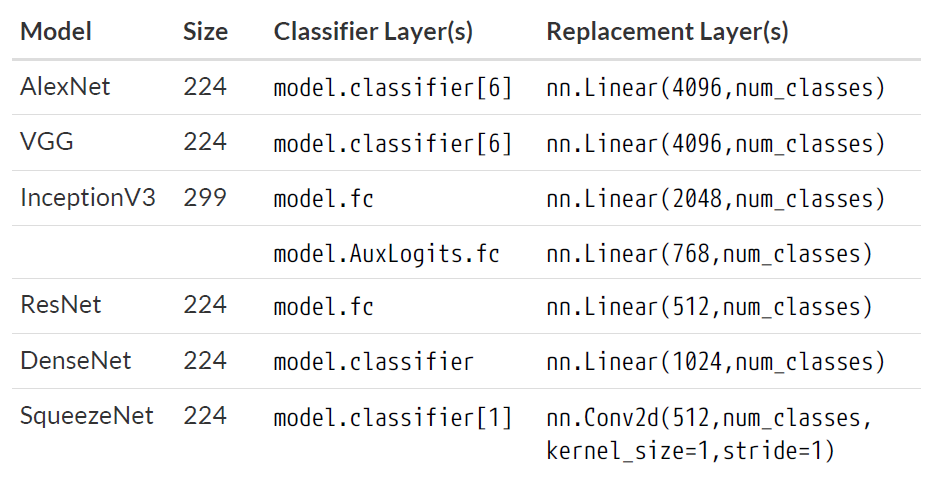

>"Why there are two layers for the Inception V3 model?"

The Inception model is a special case because it has auxiliary classifiers. We’ll
discuss them later in this chapter.

## Model Configuration

What’s missing in the model configuration? A loss function and an optimizer. A
multiclass classification problem, when the model produces logits, requires
`CrossEntropyLoss` as the loss function. For the optimizer, let’s use `Adam` with the
"Karpathy Constant" (`3e-4`) as learning rate.

In [14]:
torch.manual_seed(17)
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_alex = optim.Adam(alex.parameters(), lr=3e-4)

Cool, the model configuration is taken care of, we can turn our attention to the…

## Data Preparation

This step is quite similar to what we’ve done in the previous chapter (we’re still
using the "Rock, Paper, Scissors" dataset), except for one key difference: we will **use
different parameters for standardizing the images**.

> "So we’re not computing statistics for the images in our dataset anymore?"

Nope!

> "Why not?"

Since we’re using a pre-trained model, we need to **use the standardization
parameters used to train the original model**. In other words, **we need to use the
statistics of the original dataset used to train that model**. For AlexNet (and pretty
much every computer vision pre-trained model), these statistics were computed on
the ILSVRC dataset.

You can find these values in PyTorch’s documentation for pre-trained models:

#### ImageNet Statistics

All pre-trained models expect input images normalized in the same way, i.e.
mini-batches of 3-channel RGB images of shape (3 x H x W), where H and W
are expected to be at least 224. The images have to be normalized using `mean
= [0.485, 0.456, 0.406]` and `std = [0.229, 0.224, 0.225]`. You can use
the following transform:

```
normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
std=[0.229, 0.224, 0.225])
```

In [15]:
# This may take a couple of minutes...
download_rps() # if you ran it in Chapter 6, it won't do anything else

rps folder already exists!
rps-test-set folder already exists!


So the data preparation step for the "Rock, Paper, Scissors" dataset looks like this
now:

In [16]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])

composer = Compose([Resize(256),
                    CenterCrop(224),
                    ToTensor(),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

## Model Training

We have everything set to train the top layer of our modified version of AlexNet:

In [17]:
sbs_alex = StepByStep(alex, multi_loss_fn, optimizer_alex)
sbs_alex.set_loaders(train_loader, val_loader)
sbs_alex.train(1)

You probably noticed it took some seconds (and a lot more if you’re running on a
CPU) to run the code above, even though it is training for one single epoch.

> "How come? Most of the model is frozen, there is only one measly layer to train…"

You’re right, there is only one measly layer to **compute gradients for and to update its
parameters**, but **the forward pass still uses the whole model**. So, every single image
(out of 2,520 in our training set) will have its features computed using more than
61 million parameters! No wonder it is taking some time! By the way, only 12,291
parameters are trainable.

If you’re thinking "there must be a better way…", you’re absolutely right - that’s the
topic of the next section.

But, first, let’s see how **effective transfer learning is by evaluating our model after
training it over one epoch only**:

In [18]:
StepByStep.loader_apply(val_loader, sbs_alex.correct)

tensor([[110, 124],
        [124, 124],
        [124, 124]])

That’s 96.51% accuracy in the validation set (it is 99.33% for the training set, in
case you’re wondering). Even if it is taking some time to train, these results are
pretty good!

## Generating a Dataset of Features

We’ve just realized that, from the time it takes to train the last layer of our model
over one single epoch, most of it was spent in the forward pass. Now, imagine if we
wanted to train it over ten epochs: not only the model would spend most of its time
performing the forward pass but, even worse, **it would perform the same
operations ten times over**.


> Since all layers but the last are frozen, the output of the second
to last layer is always the same.
That’s assuming you’re not doing data augmentation, of course.


**What can we do about it?**

Since the frozen layers are simply generating features that will be the input
of the trainable layers, why not treat the frozen layers as such? We could do it in
four easy steps:

- keep only the frozen layers in the model
- run the whole dataset through it and **collect its outputs as a dataset of features**
- **train a separate model** (that corresponds to the "top" of the original model) using the dataset of features.
- **attach** the trained model to the top of the frozen layers

To keep only the frozen layers, we need to get rid of the "top" of the original model.
But, since we also want to attach our new layer to the whole model after training,
it is **a better idea to simply replace the "top" layer with an identity layer instead of
removing it**:

In [19]:
alex.classifier[6] = nn.Identity()
print(alex.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Identity()
)


This way, the last effective layer still is `classifier.5`, which will produce the
features we’re interested in. We have a **feature extractor** in our hands now! Let’s
use it to pre-process our dataset.

The function below: 
- loops over the mini-batches from a data loader, 
- sends them through our feature extractor model, 
- combines the outputs with the corresponding labels and
- returns a TensorDataset:

In [20]:
def preprocessed_dataset(model, loader, device=None):
    if device is None:
        device = next(model.parameters()).device
    
    features = None
    labels = None

    for i, (x, y) in enumerate(loader):
        model.eval()
        x = x.to(device)
        output = model(x)
        if i == 0:
            features = output.detach().cpu()
            labels = y.cpu()
        else:
            features = torch.cat([features, output.detach().cpu()])
            labels = torch.cat([labels, y.cpu()])

    dataset = TensorDataset(features, labels)
    return dataset

We can use it to pre-process our datasets:

In [21]:
train_preproc = preprocessed_dataset(alex, train_loader)
val_preproc = preprocessed_dataset(alex, val_loader)

There we go, we have TensorDatasets containing tensors for features generated
by AlexNet for each and every image, as well as for the corresponding labels.

> **IMPORTANT**: this pre-processing step assumes no data
augmentation. If you want to perform data augmentation you
will need to train the top of the model while it is still attached to
the rest of the model since the features produced by the frozen
layers will be slightly different every time due to the
augmentation itself.

We can also save these tensors to disk:

In [22]:
torch.save(train_preproc.tensors, 'rps_preproc.pth')
torch.save(val_preproc.tensors, 'rps_val_preproc.pth')

So they can be used to build datasets later:

In [23]:
x, y = torch.load('rps_preproc.pth')
train_preproc = TensorDataset(x, y)
val_preproc = TensorDataset(*torch.load('rps_val_preproc.pth'))

The last step of the data preparation, as usual, is the creation of the data loader:

In [24]:
train_preproc_loader = DataLoader(train_preproc, batch_size=16, shuffle=True)
val_preproc_loader = DataLoader(val_preproc, batch_size=16)

Bye, bye, costly and repetitive forward passes! We can now focus on training our…

## Top Model

The model has only one layer, which matches the one we used in the "Top of the
Model" subsection. The rest of the model configuration part remains unchanged:

In [25]:
torch.manual_seed(17)
top_model = nn.Sequential(nn.Linear(4096, 3))
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_top = optim.Adam(top_model.parameters(), lr=3e-4)

Next, we create another StepByStep instance to train the model above using the
pre-processed dataset. Since it is a tiny model, we can afford to train it over ten
epochs, instead of only one:

In [26]:
sbs_top = StepByStep(top_model, multi_loss_fn, optimizer_top)
sbs_top.set_loaders(train_preproc_loader, val_preproc_loader)
sbs_top.train(10)

See? That was blazing fast!
Now we can attach the trained model to the top of the full (frozen) model:

In [27]:
sbs_alex.model.classifier[6] = top_model

print(sbs_alex.model.classifier)

Sequential(
  (0): Dropout(p=0.5, inplace=False)
  (1): Linear(in_features=9216, out_features=4096, bias=True)
  (2): ReLU(inplace=True)
  (3): Dropout(p=0.5, inplace=False)
  (4): Linear(in_features=4096, out_features=4096, bias=True)
  (5): ReLU(inplace=True)
  (6): Sequential(
    (0): Linear(in_features=4096, out_features=3, bias=True)
  )
)


The sixth element of the classifier part corresponds to our small trained model.
Let’s see how it performs on the validation set.

> We’re using the full model again, so we should use the original
dataset instead of the pre-processed one.

In [28]:
StepByStep.loader_apply(val_loader, sbs_alex.correct)

tensor([[109, 124],
        [124, 124],
        [124, 124]])

It is almost the same result as before. The model is probably overfitting, but it
doesn’t matter because the purpose of this exercise was to show you how to use
transfer learning and how you can pre-process your dataset to speed up model
training.

AlexNet was fun to work with, but it is time to move on.

In the next sections, we’ll focus on new architectural elements that are part of **Inception** and **ResNet** models.

# Auxiliary Classifiers (Side-Heads)

The first version of the Inception model (depicted in the figure below) introduced
auxiliary classifiers, that is, **side-heads** attached to intermediate parts of the model
that would also try to perform classification, **independently from the typical main
classifier at the very end of the network**:

![](images/inception_model.png)

The **cross-entropy loss was also computed independently** for each one of the
three classifiers and added together to the total loss (although auxiliary losses
were multiplied by a factor of 0.3). The auxiliary classifiers (and losses) were used
during training time only. **During the evaluation phase, only the logits produced by
the main classifier were considered.**

The technique was originally developed to mitigate the **vanishing gradients**
problem (more on that in the next chapter), but it was later found that the auxiliary
classifiers are more likely to have a **regularizer effect instead**[122].

The third version of the Inception model (inception_v3), available as a pre-trained
model in PyTorch, has **only one auxiliary classifier instead of two**, but we still need
to make some adjustments if we’re using this model for transfer learning.

First, we load the pre-trained model, freeze its layers, and replace the layers for
both main and auxiliary classifiers:

In [29]:
model = inception_v3(pretrained=True)
freeze_model(model)

torch.manual_seed(42)
model.AuxLogits.fc = nn.Linear(768, 3)
model.fc = nn.Linear(2048, 3)

Unfortunately, we cannot use the standard cross-entropy loss because the
Inception model **outputs two tensors**, one for each classifier (although it is possible
to force it to return only the main classifier by setting its aux_logits argument to
False). But we can create **a simple function that can handle multiple outputs**,
computing the corresponding losses and returning their total:

In [30]:
def inception_loss(outputs, labels):
    try:
        main, aux = outputs
    except ValueError:
        main = outputs
        aux = None
        loss_aux = 0
        
    multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
    loss_main = multi_loss_fn(main, labels)
    if aux is not None:
        loss_aux = multi_loss_fn(aux, labels)
    return loss_main + 0.4 * loss_aux

The auxiliary loss, in this case, is multiplied by a factor of 0.4 before being added to
the main loss. Now, we’re only missing an optimizer:

In [31]:
optimizer_model = optim.Adam(model.parameters(), lr=3e-4)
sbs_incep = StepByStep(model, inception_loss, optimizer_model)

> "Wait, aren’t we pre-processing the dataset this time?"

Unfortunately, no. The `preprocessed_dataset` cannot handle multiple outputs.
Instead of making the process too convoluted in order to handle the peculiarities of
the Inception model, I am sticking with the simpler (yet slower) way of training the
last layer while it is still attached to the rest of the model.

The Inception model is also different from the others in its expected input size: 299
instead of 224. So, we need to recreate the data loaders accordingly:

In [32]:
normalizer = Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])

composer = Compose([Resize(299),
                    ToTensor(),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

We’re ready, let’s train our model for a single epoch and evaluate the result:

In [33]:
sbs_incep.set_loaders(train_loader, val_loader)
sbs_incep.train(1)

In [34]:
StepByStep.loader_apply(val_loader, sbs_incep.correct)

tensor([[105, 124],
        [ 77, 124],
        [117, 124]])

It achieved an accuracy of 89.25% on the validation set. Not bad!

There is more to the Inception model than auxiliary classifiers, though. Let’s check
other architectural elements it contains.

# 1x1 Convolutions

This particular architectural element is not exactly new, but it is a somewhat special
case of an already known element. So far, the **smallest kernel** used in a
convolutional layer had a size **three-by-three**. These kernels performed an
element-wise multiplication and then added up the resulting elements to produce
a single value for each region they were applied to. So far, nothing new.

The idea of a kernel of size **one-by-one** is somewhat counterintuitive at first. For a
single channel, this kernel is only **scaling** the values of its input and nothing else.
That seems hardly useful…

But everything changes if you have **multiple channels**! Remember the three channel
convolutions from Chapter 6? **A filter has as many channels as its input**. It
means that each channel will be **scaled independently** and the results will be added up, resulting in **one channel as output** (per filter). 

> A 1x1 convolution can be used to reduced the number of channels, that is, it may work as a **dimension reduction layer**.

An image is worth a thousand words, so let’s visualize this:

![](images/1conv1.png)

The input is an RGB image and there are two filters, each filter has three 1x1
kernels, one for each channel of the input. What are these filters actually doing?
Let’s check it out:

![](images/1conv2.png)

Maybe it is even more clear if it is presented as a formula:

$$
\Large
\begin{array}
&\text{Filter 1}: -&1& \text{R} &+& 2& \text{G} &+& 0& \text{B}
\\
\text{Filter 2}: &2& \text{R} &+& 0& \text{G} &-& 2& \text{B}
\end{array}
$$

> A filter using a 1x1 convolution corresponds to a **weighted
average** of the input channels.
In other words, a 1x1 convolution is a **linear combination of the
input channels**, computed pixel by pixel.

There is another way to get a **linear combination of the inputs**: a linear layer, also
referred to as a fully connected layer. Performing a 1x1 convolution is akin to
**applying a linear layer to each individual pixel over its channels.**

In the example above, each one of the two filters produces a different linear
combination of the RGB channels. Does this ring any bells? In Chapter 6, we’ve
seen that grayscale images can be computed using a linear combination of the red,
green, and blue channels of colored images. So, we can **convert an image to
grayscale** using a 1x1 convolution!

In [35]:
scissors = Image.open('rps/scissors/scissors01-001.png')
image = ToTensor()(scissors)[:3, :, :].view(1, 3, 300, 300)

weights = torch.tensor([0.2126, 0.7152, 0.0722]).view(1, 3, 1, 1)
convolved = F.conv2d(input=image, weight=weights)

converted = ToPILImage()(convolved[0])
grayscale = scissors.convert('L')

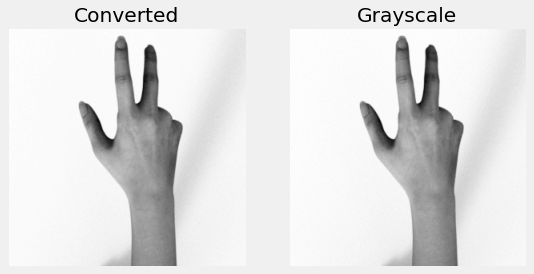

In [36]:
fig = compare_grayscale(converted, grayscale)

See? They are the same… or are they? If you have a really sharp eye, maybe you are
able to notice a subtle difference between the two shades of gray. It doesn’t have
anything to do with the use of convolutions, though… it turns out, PIL uses slightly
different weights for converting RGB into grayscale.

> The weights used by PIL are 0.299 for red, 0.587 for blue, and
0.114 for green, the "ITU-R 601-2 luma transform". Our weights
were different because we used the colorimetric conversion to
grayscale. If you want to learn more about it, check Wikipedia’s
article on Grayscale[123].

You can think of converting colored images to grayscale as reducing the
dimensions of the image since the size of the output is one-third of the input size
(one instead of three channels). This translates into having three times fewer
parameters in the layer that is receiving it as its own input, and it allows the
networks to grow deeper (and wider).

# Inception Modules

Memes aside, let’s talk about the inception module. There are many versions of it, as
it evolved over time, but we’re focusing on the first two only: the regular version, and the one with **dimension reductions**. Both versions are depicted in the figure
below:

![](images/inception_modules.png)

In the regular version, the 1x1 convolution is **not used** as a dimension reduction
layer. Each one of the convolution branches is producing a given number of
channels, and the max-pooling branch produces as many channels as it receives as
input. In the end, all channels are stacked (concatenated) together.

> "Honestly, I am a bit confused with channels and filters… are they
the same or not?! How about kernels?"

This is a bit confusing indeed… let’s try to organize our thoughts about filters,
kernels, and channels.

This is what we have seen so far:

1. every filter has as many channels as the image it is convolving (input)
2. each channel of the filter/kernel is a small square matrix (that is being convolved over the corresponding input channel)
3. a convolution produces as many channels as there are filters (output)

For example, we may have an RGB image as input (three channels) and use two
filters (each having three channels of its own to match the input (1)) to produce
two channels as output (3).

But things can get very messy if we start using "filter" to designate other things:

- each channel of a filter/kernel **is often referred to as a "filter" itself**
- each channel of the output produced by convolving the filter over the input image is often referred to as a "filter" too.

In the example, we would then have six "filters" (instead of two filters with three
channels each), and we would produce two "filters" as output (instead of two
channels). This is confusing!

We’re avoiding these messy definitions here, so we’re using **channel
concatenation** (or even better, stacking) instead of the confusing "filter
concatenation".

Having cleared that out, we can return to the inception module itself. As we’ve
seen, the regular version is simply stacking the output channels of convolutions
with different filter/kernel sizes. What about the other version?

It also does that, but the inception module with dimension reductions uses 1x1
convolutions to:

- reduce the number of input channels for both 3x3 and 5x5 convolution branches
- reduce the number of output channels for the max-pooling branch

The 3x3 and 5x5 convolution branches may still output many channels (one for
each filter), but each filter is convolving a reduced number of input channels.

You can think of the RGB to grayscale conversion: instead of using three-channel
convolutions (as in Chapter 6) for colored images, it would use a single-channel
filter (as in Chapter 5) for the grayscale (dimension reduced) image. For a 3x3
filter/kernel, it means using nine parameters instead of twenty-seven. We can
definitely go deeper!

Let’s see how the inception module looks like in code:

In [37]:
class Inception(nn.Module):
    def __init__(self, in_channels):
        super(Inception, self).__init__()
        # in_channels@HxW -> 2@HxW
        self.branch1x1_1 = nn.Conv2d(in_channels, 2, kernel_size=1)

        # in_channels@HxW -> 2@HxW -> 3@HxW
        self.branch5x5_1 = nn.Conv2d(in_channels, 2, kernel_size=1)
        self.branch5x5_2 = nn.Conv2d(2, 3, kernel_size=5, padding=2)

        # in_channels@HxW -> 2@HxW -> 3@HxW
        self.branch3x3_1 = nn.Conv2d(in_channels, 2, kernel_size=1)
        self.branch3x3_2 = nn.Conv2d(2, 3, kernel_size=3, padding=1)

        # in_channels@HxW -> in_channels@HxW -> 1@HxW
        self.branch_pool_1 = nn.AvgPool2d(kernel_size=3, stride=1, padding=1)
        self.branch_pool_2 = nn.Conv2d(in_channels, 2, kernel_size=1)

    def forward(self, x):
        # Produces 2 channels
        branch1x1 = self.branch1x1_1(x)
        # Produces 3 channels
        branch5x5 = self.branch5x5_1(x)
        branch5x5 = self.branch5x5_2(branch5x5)
        # Produces 3 channels
        branch3x3 = self.branch3x3_1(x)
        branch3x3 = self.branch3x3_2(branch3x3)
        # Produces 2 channels
        branch_pool = self.branch_pool_1(x)
        branch_pool = self.branch_pool_2(branch_pool)
        # Concatenates all channels together (10)
        outputs = torch.cat([branch1x1, branch5x5, branch3x3, branch_pool], 1)
        return outputs        

The constructor method defines the seven elements used by four branches (you
can identify each one of them in the figure above). In this example, I’ve configured
all 1x1 convolutions to produce two channels each, but it is not required that they
all have the same number of output channels. The same applies to both 3x3 and
5x5 convolution branches: although I’ve configured them both to produce the same
number of channels (three) each, this is not a requirement.


> It is required, though, that all branches produce outputs with
**matching height and width**. This means that the padding must be
adjusted according to the kernel size in order to output the
correct dimensions.

The forward method feeds the input `x` to each one of the four branches, and then it
uses `torch.cat` to concatenate the resulting channels along the corresponding
dimension (according to PyTorch’s NCHW shape convention). This concatenation
**would fail if the height and width of the outputs did not match across the different
branches.**

What if we run our example image (scissors, in the color version) through the
inception module?

In [38]:
inception = Inception(in_channels=3)
output = inception(image)
output.shape

torch.Size([1, 10, 300, 300])

There we go, the output has the expected 10 channels.

As you can see, the idea behind the inception module is actually quite simple. Later
versions had slightly different architectures (like switching the 5x5 convolution by
two 3x3 convolutions in a row, but the overall structure remains. There is one
more thing, though…

If you check Inception’s code in PyTorch, **you’ll find out that it does not use
`nn.Conv2d` directly**, but something called `BasicConv2d` instead (reproduced below):

In [39]:
class BasicConv2d(nn.Module):
    def __init__(self, in_channels, out_channels, **kwargs):
        super(BasicConv2d, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, bias=False, **kwargs)
        self.bn = nn.BatchNorm2d(out_channels, eps=0.001)

    def forward(self, x):
        x = self.conv(x)
        x = self.bn(x)
        return F.relu(x, inplace=True)

Sure, its main component still is nn.Conv2d, but **it also applies a ReLU activation
function to the final output**. More importantly, though, it calls `nn.BatchNorm2d`
between the two.

> "What is that?"

That is…

# Batch Normalization

The batch normalization layer is a very important component of
many modern architectures. Although its inner workings are not
exactly complex (you’ll see that in the following paragraphs), its
impact on model training certainly is complex. From its
placement (before or after an activation function) to the way its
behavior is impacted by the mini-batch size, I try to briefly
address the main discussion points in asides along the main text.
This is meant to bring you up to speed on this topic, but it is by no
means a comprehensive take on it. 

We’ve briefly talked about the need for normalization layers in Chapter 4 to
prevent (or mitigate) an issue commonly called **"internal covariate shift"**, which is
just fancy for **different distributions of activation values in different layers**. In
general, we would like to have all layers producing activation values with similar
distributions, ideally with **zero mean and unit standard deviation**.

Does it sound familiar? That’s what we did with our features way back in Chapter 0,
we standardized them.

Now, batch normalization will be doing something very similar to it, but with some
important differences:

- instead of standardizing features, the inputs to the model as a whole, **batch normalization standardizes the activation values of a layer**, that is, the inputs
to the following layer, so that they have zero mean and unit standard deviation

- instead of computing statistics (mean and standard deviation) for the whole training set, batch normalization computes statistics **for each mini-batch**

- batch normalization may perform an optional **affine transformation** to the standardized output, that is, scaling it and adding a constant to it (in this case, both scaling factor and constant are **parameters learned by the model**)

---

### Before or after

There is a very common question regarding batch normalization:

> "Should I place the batch norm layer **before** or **after** the activation function?"

From what I said above, that batch normalization standardizes the
activation values of a layer, the only logical conclusion is that the batch
normalization layer comes **AFTER** the activation function. It makes sense,
right? Placing an activation function after normalizing would completely
modify the inputs to the next layer and defeat the purpose of the batch
normalization.

Or would it?

Some people argue that it is OK to place the batch normalization layer
**BEFORE** the activation function. In fact, if you look at the Inception module,
it is exactly like that. On the one hand, the outputs aren’t going to have zero
mean and unit standard deviation (a ReLU would chop the negative values
off, for instance). On the other hand, the same should happen in every layer
using batch normalization placed like that, so distributions are still similar
across different layers.

So, **there is no easy answer to this question.**

---

For a mini-batch of n data points, given one particular feature x, batch
normalization will first compute the statistics for that mini-batch:

$$
\Large
\overline{X} = \frac{1}{n}\sum_{i=1}^n{x_i}
\\
\Large
\sigma(X) = \sqrt{\frac{1}{n}\sum_{i=1}^n{(x_i - \overline{X})^2}}
$$

Then, it will use these statistics to standardize each data point in the mini-batch:

$$
\Large
\text{standardized }x_i = \frac{x_i-\overline{X}}{\sigma(X)+ \epsilon}
$$

So far, this is **pretty much the same as the standardization of features**, except for
the epsilon term added to the denominator to make it numerically stable (its
typical value is 1e-5).

> Since the batch normalization layer is meant to produce a zero
mean output, it makes the **`bias` in the layer that precedes it is
totally redundant**. It would be a waste of computation to learn a
bias that will be immediately removed by the following layer.

> So, it is best practice to **set `bias=False` in the preceding layer**
(you can check it out on the code for BasicConv2d in the previous
section).

The actual difference is the **optional affine transformation** at the end:

$$
\Large
\text{batch normed }x_i = b + w \text{ standardized }x_i
$$

If you choose not to perform an affine transformation, it will automatically set
parameters b and w to zero and one, respectively. Although I’ve chosen the
familiar b and w to represent these parameters, so it becomes even more clear
there is nothing special to this transformation, you’ll find them represented as beta
and gamma, respectively, in the literature. Moreover, the terms may appear in a
different order, like this:

$$
\Large
\text{batch normed }x_i = \text{standardized }x_i\ \gamma + \beta
$$

We’re leaving the affine transformation aside, and focusing on a different aspect of
the batch normalization: **it does not only compute statistics for each mini-batch,
but it also keeps track of…**

## Running Statistics

Since batch normalization computes statistics on mini-batches, and mini-batches
contain a small number of points, these statistics are likely to **fluctuate** a lot. *The
smaller the mini-batches, the more the statistics will fluctuate*. But, more
importantly, **which statistics should it use for unseen data** (like the data points in
the validation set)?

**During the evaluation phase (or when the model is already trained and deployed),
there are no mini-batches**. It is perfectly natural to feed the model a single input to
get its prediction. Clearly, there are no statistics for a single data point: it is its own
mean, and the variance is zero. How can you standardize that? You can’t! 

---

### Affine transformations and the Interval Covariate Shift (ICS)

If batch normalization was developed to mitigate the ICS (remember, this is
just fancy for different distributions of activation values in different layers)
by producing outputs with zero mean and unit standard deviation, **how can
an affine transformation possibly fit into this?**

Well, in theory, it can’t… if the normalization layer can learn any affine
transformation, its outputs may have any mean and any standard deviation.
So much for producing similar distributions across different layers to
mitigate the internal covariate shift!

Nonetheless, the batch normalization layer in PyTorch performs an affine
transformation by default.

If you look at the Inception module, it uses PyTorch’s default. So, its batch
norm layer not only performs an affine transformation but also is placed
before the activation function. Clearly, this isn’t mitigating ICS at all! But it is
still successfully used in many model architectures, like Inception. How
come?

Truth to be told, mitigating the ICS was the **original motivation** behind batch
normalization, but it was later found that **this technique actually improves
model training for a different reason**[124]. That’s a plot twist!

It all boils down to making the **loss surface smoother**. We’ve actually already
seen the effect of using standardization on the loss surface in Chapter 0: it
became more bowl-shaped, thus making it easier for gradient descent to find
the minimum. Can you imagine that in a thousand-dimension feature space?
No?! Me neither! But hold on to this thought because we’ll get back to it in
the "Residual Connections" section.

---

So, I repeat the question:

> "Which statistics should the model use when applying batch normalization to **unseen data**?"

What about keeping track of running statistics (that is, **moving averages** of the
statistics)? It is a good way of smoothing the fluctuations. Besides, every data point
will have a chance to contribute to the statistics. That’s what batch normalization
does.

Let’s see it in action using code… we’ll use a dummy dataset with 200 random data
points and two features:

In [40]:
torch.manual_seed(23)
dummy_points = torch.randn((200, 2)) + torch.rand((200, 2)) * 2
dummy_labels = torch.randint(2, (200, 1))
dummy_dataset = TensorDataset(dummy_points, dummy_labels)
dummy_loader = DataLoader(dummy_dataset, batch_size=64, shuffle=True)

A mini-batch of size 64 is small enough to have fluctuating statistics and big enough
for plotting decent histograms.

---
#### Batch Normalization, Mini-Batch Size, and Regularization

It is said that batch normalization **enforces a lower limit on mini-batch size**.

The problem is the natural fluctuation of the statistics. As mentioned above,
the smaller the mini-batches, the more the statistics will fluctuate. If they are
too small, their statistics may significantly diverge from the overall
statistics for the whole training set, thus impacting negatively the training
of the model.

There is also the possibility of using **batch renormalization** (yes, that’s a
thing!) for those cases where it’s impossible to have larger mini-batches (due
to hardware constraints, for example) to prevent the issue above. This
technique is beyond the scope of this book, though.

The flip side is that the fluctuation of the statistics is actually **injecting
randomness in the training process, thus having a regularizing effect** and
impacting positively the training of the model.

In Chapter 6, we’ve discussed another regularization procedure: dropout. Its
way of injecting randomness was zeroing some of the inputs, such that its
output would also vary slightly, or fluctuate.

**Since both batch normalization and dropout layers have a regularizing effect,
combining both layers may actually harm the model performance.**

---


Let’s fetch three mini-batches, and plot histograms corresponding to each feature
in the first mini-batch:

In [41]:
iterator = iter(dummy_loader)
batch1 = next(iterator)
batch2 = next(iterator)
batch3 = next(iterator)

In [42]:
mean1, var1 = batch1[0].mean(axis=0), batch1[0].var(axis=0)
mean1, var1

(tensor([0.9850, 1.0381]), tensor([1.4802, 1.1832]))

In [43]:
def before_batchnorm(batch):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for i in range(2):
        feature = batch[0][:, i]
        #return feature
        pd.Series(feature.numpy()).hist(ax = axs[i])
        #axs[i].hist(feature, bins = [-2, 0, 2]) #bins=np.linspace(-3, 3, 15), alpha=.5)
        axs[i].set_xlabel(f'Feature #{i}')
        axs[i].set_ylabel('# of points')
        axs[i].set_title(f'mean={feature.mean():.4f} var={feature.var():.4f}')
        axs[i].set_ylim([0, 13])
        axs[i].label_outer()
    fig.tight_layout()
    return fig

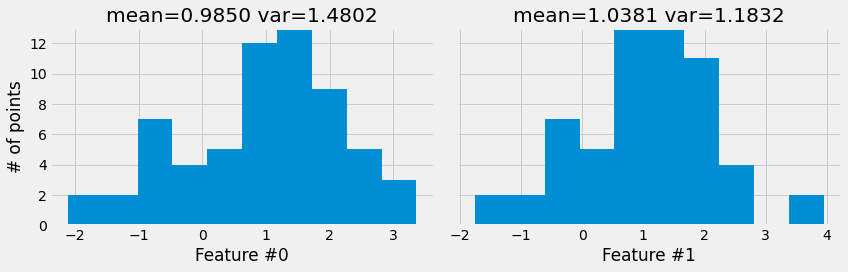

In [44]:
fig = before_batchnorm(batch1)

These features can surely benefit from some standardization. We’ll use
`nn.BatchNorm1d` to accomplish it:

In [45]:
batch_normalizer = nn.BatchNorm1d(num_features=2, affine=False, momentum=None)
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([0., 0.])),
             ('running_var', tensor([1., 1.])),
             ('num_batches_tracked', tensor(0))])

The num_features argument should match the dimension of the inputs. To keep
matters simple, we won’t be using the affine transformation (affine=False), and neither the momentum (more on that later in this section).

The `state_dict` of the batch normalizer tells us the initial values for both running
mean and variance, as well as the number of batches it has already used to compute
the running statistics. Let’s see what happens to them after we normalize our first
mini-batch:

In [46]:
normed1 = batch_normalizer(batch1[0])
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([0.9850, 1.0381])),
             ('running_var', tensor([1.4802, 1.1832])),
             ('num_batches_tracked', tensor(1))])

Great, it matches the statistics we’ve computed before. **The resulting values should
be standardized by now, right? Let’s double-check it:**

In [47]:
normed1.mean(axis=0), normed1.var(axis=0)

(tensor([3.7253e-09, 2.3283e-08]), tensor([1.0159, 1.0159]))

> "This looks a bit off… shouldn’t the variance be exactly one?"

Yes, and no. I confess I find this a bit annoying too… the running variance is
unbiased, but the actual standardization of the data points of a mini-batch uses a
biased variance.

> "What’s the difference between the two?"

The difference lies in the denominator only:

$$
\Large
\begin{aligned}
\text{Biased Var}(X) &= \frac{1}{n} &\sum_{i=1}^n{(x_i - \overline{X})^2}
\\
\text{Var}(X) &= \frac{1}{n-1} &\sum_{i=1}^n{(x_i - \overline{X})^2}
\end{aligned}
$$

This was actually implemented like that by design. We’re not discussing the
reasoning here but, if you’d like to double-check the variance of the standardized
mini-batch, you can use the following:

In [48]:
normed1.var(axis=0, unbiased=False)

tensor([1.0000, 1.0000])

That’s more like it! We can also plot the histograms once again to more easily
visualize the effect of batch normalization:

In [49]:
def after_batchnorm(batch, normalized):
    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    for i in range(2):
        feature = batch[0][:, i]
        normed = normalized[:, i]
        pd.Series(feature.numpy()).hist(ax = axs[i], label = 'Original')
        pd.Series(normed.numpy()).hist(ax = axs[i], label = 'Standardized')
        #axs[i].hist(feature, bins=np.linspace(-3, 3, 15), alpha=.5, label='Original')
        #axs[i].hist(normed, bins=np.linspace(-3, 3, 15), alpha=.5, label='Standardized')
        axs[i].set_xlabel(f'Feature #{i}')
        axs[i].set_ylabel('# of points')
        axs[i].set_title(f'mean={normed.mean():.4f} std={normed.std(unbiased=False):.4f}')
        axs[i].legend()
        axs[i].set_ylim([0, 13])
        axs[i].label_outer()
    fig.tight_layout()
    return fig

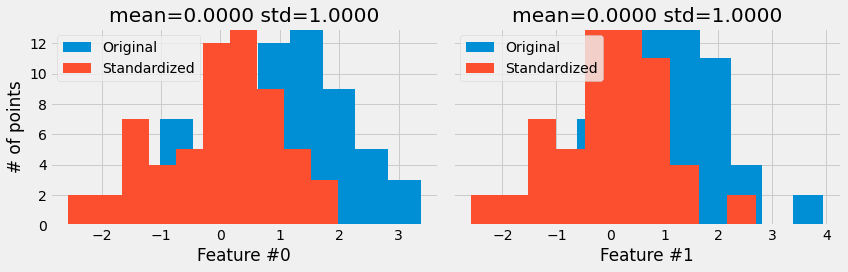

In [50]:
fig = after_batchnorm(batch1, normed1)

Event though batch normalization achieved an output with zero mean and **unit standard deviation**, the overall distribution of the output is still mostly **determined
by the distribution of the inputs.**

> Batch normalization **won’t turn it into a normal distribution.**

If we feed the second mini-batch to the batch normalizer, it will update its running
statistics accordingly:

In [51]:
normed2 = batch_normalizer(batch2[0])
batch_normalizer.state_dict()

OrderedDict([('running_mean', tensor([0.9611, 0.9964])),
             ('running_var', tensor([1.4247, 1.0460])),
             ('num_batches_tracked', tensor(2))])

Both running mean and running variance are simple averages over the minibatches:

In [52]:
mean2, var2 = batch2[0].mean(axis=0), batch2[0].var(axis=0)
running_mean, running_var = (mean1 + mean2) / 2, (var1 + var2) / 2
running_mean, running_var

(tensor([0.9611, 0.9964]), tensor([1.4247, 1.0460]))

Now, let’s pretend we have **finished training** (even though we don’t have an actual
model), and we’re using the third mini-batch for evaluation.

## Evaluation Phase

Just like dropout, batch normalization also **exhibits different behaviors** depending
on the mode: `train()` or `eval()`. We’ve already seen what it does during the
training phase. We’ve also realized that it doesn’t make sense to compute
statistics for any data that isn’t training data.

So, in the evaluation phase, it will use the running statistics computed during
training to standardize the new data (the third mini-batch, in our small example):

In [53]:
batch_normalizer.eval()
normed3 = batch_normalizer(batch3[0])
normed3.mean(axis=0), normed3.var(axis=0, unbiased=False)

(tensor([-0.0201,  0.2208]), tensor([0.7170, 1.0761]))

>"Is it a bit off again?"

Actually, no… since it is standardizing unseen data using statistics computed on
training data, the results above are expected. The mean will be around zero and
the standard deviation will be around one.

## Momentum

There is an alternative way of computing running statistics: instead of using a
simple average, it uses an **exponentially weighted moving average of the statistics.**

The naming convention, though, is very unfortunate: **the alpha parameter of the
EWMA was named momentum, adding to the confusion**. There is even a note in
PyTorch’s documentation warning about this:

> "This momentum argument is different from one used in optimizer classes and the
conventional notion of momentum."[125]

> The bottom line is: ignore the confusing naming convention and
think of the "momentum" argument as the alpha parameter of a
regular EWMA.

The documentation also uses x to refer to a particular statistic when introducing
the mathematical formula of the "momentum", which does not help at all.

So, to make it abundantly clear what is being computed, I present you the formulas
below:

$$
\large
\begin{array}
& \text{EWMA}_t(\alpha, x) &= &\alpha &x_t &+ &(1-\alpha) &\text{EWMA}_{t-1}(\alpha, x)
\\
\text{running stat}_t &= &\text{"momentum"} &\text{stat}_t &+ &(1-\text{"momentum"}) &\text{running stat}_{t-1}
\end{array}
$$

Let’s try it out in practice:

In [54]:
batch_normalizer_mom = nn.BatchNorm1d(num_features=2, affine=False, momentum=0.1)
batch_normalizer_mom.state_dict()

OrderedDict([('running_mean', tensor([0., 0.])),
             ('running_var', tensor([1., 1.])),
             ('num_batches_tracked', tensor(0))])

Initial values are zero and one, respectively, for running mean and running
variance. These will be the running statistics at time $t-1$. What happens if we run
the first mini-batch through it?

In [55]:
normed1_mom = batch_normalizer_mom(batch1[0])
batch_normalizer_mom.state_dict()

OrderedDict([('running_mean', tensor([0.0985, 0.1038])),
             ('running_var', tensor([1.0480, 1.0183])),
             ('num_batches_tracked', tensor(1))])

The running statistics barely budged since the mini-batch statistics were multiplied
by the "momentum" argument. We can easily verify the results for the running
means:

In [56]:
running_mean = torch.zeros((1, 2))
running_mean = 0.1 * batch1[0].mean(axis=0) + (1 - 0.1) * running_mean
running_mean

tensor([[0.0985, 0.1038]])

> "Very well, but we have only used BatchNorm1d so far, and the
inception module actually used BatchNorm2d…"

Glad you brought that up!

## BatchNorm2d

The difference between the one-dimension and the two-dimensions batch
normalization is actually quite simple: **the former standardized features (columns),
while the latter standardizes channels (pixels).**

This is easier to see in code:

In [58]:
torch.manual_seed(39)
dummy_images = torch.rand((200, 3, 10, 10))
dummy_labels = torch.randint(2, (200, 1))
dummy_dataset = TensorDataset(dummy_images, dummy_labels)
dummy_loader = DataLoader(dummy_dataset, batch_size=64, shuffle=True)

iterator = iter(dummy_loader)
batch1 = next(iterator)
batch1[0].shape

torch.Size([64, 3, 10, 10])

The code above creates a dummy dataset of 200 colored (three-channel) images of
size 10x10 pixels and then retrieves the first mini-batch. The mini-batch has the
expected NCHW shape.

The batch normalization is done over the C dimension, so it will compute statistics
using the remaining dimensions: N, H, and W (`axis=[0, 2, 3]`), representing all
pixels of a given channel from every image in the mini-batch.

The `nn.BatchNorm2d` layer has the same arguments as its one-dimension
counterpart, but its `num_features` argument must match the number of channels
of the input instead:

In [59]:
batch_normalizer = nn.BatchNorm2d(num_features=3, affine=False, momentum=None)
normed1 = batch_normalizer(batch1[0])
normed1.mean(axis=[0, 2, 3]), normed1.var(axis=[0, 2, 3], unbiased=False)

(tensor([ 1.9148e-08, -2.3544e-08,  9.0078e-08]),
 tensor([0.9999, 0.9999, 0.9999]))

As expected, each channel in the output has its pixel values with zero mean and
unit standard deviation.

#### Other Normalizations

Batch normalization is certainly the most popular kind of normalization, but not the
only one. If you check PyTorch’s documentation on **Normalization Layers**, you’ll see
many alternatives, like the **SyncBatchNorm**, for instance. But, just like the batch
renormalization technique, they are beyond the scope of this book.

### Small Summary

This was probably the most challenging section in this book so far. At the same
time, it goes over a lot of information and only scratches the surface of this topic.
So, I am organizing a small summary of the main points we’ve addressed:

- during **training time**, it computes **statistics** (mean and variance) for each individual mini-batch and uses these statistics to produce **standardized outputs**
- the **fluctuations** in the statistics, from one mini-batch to the next, introduce **randomness** into the process thus having a **regularizing effect.**
- due to the regularizing effect of batch normalization, **it may not work well if combined with other regularization techniques (like dropout)**
- during evaluation time, it uses a (smoothed) average of the statistics computed during training
- its original motivation was addressing the so-called "internal covariate shift" by producing similar distributions across different layers, but it was later found that **it actually improves model training by making the loss surface smoother**
- the batch normalization may be placed either **before or after the activation function**, there is no "right" or "wrong" way
- the layer **preceding the batch normalization layer** should have its `bias=False` set to avoid useless computation
- even though batch normalization works for a different reason than initially thought, addressing the "internal covariate shift" may still bring benefits, like **solving the vanishing gradients problem**, one of the topics of the next chapter.

So, we’ve learned that batch normalization speeds up training by making the loss
**surface smoother**. It turns out, there is yet another technique that works along
these lines…

# Residual Connections

The idea of a residual connection is quite simple, actually: after passing the input
through a layer and activation function, **the input itself is added to the result.**
That’s it! Simple, elegant, and effective.

> "Why would I want to add the input to the result?"

## Learning the Identity

Neural networks and their nonlinearities (activation functions) are great! We’ve
seen in the "Bonus" chapter how models manage to twist and turn the feature
space so much so that **classes can be separated by a straight line in the transformed feature space**. But nonlinearities are both a blessing and a curse: they
make it **extremely hard for a model to learn the identity function.**

To illustrate this, let’s start with a dummy dataset containing 100 random data
points with a single feature. **But this feature isn’t simply a feature, it is also the
label**. The data preparation is fairly straightforward

In [64]:
torch.manual_seed(23)
dummy_points = torch.randn((100, 1))
dummy_dataset = TensorDataset(dummy_points, dummy_points)
dummy_loader = DataLoader(dummy_dataset, batch_size=16, shuffle=True)

If we were using a simple linear model, that would be a no-brainer, right? The
model would just keep the input as it is (multiplying it by one - the weight- and
adding zero to it - the bias). But what happens if we introduce a nonlinearity? Let’s
configure the model and train it to see what happens:

In [74]:
class Dummy(nn.Module):
    def __init__(self):
        super(Dummy, self).__init__()
        self.linear = nn.Linear(1, 1)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        out = self.linear(x)
        out = self.activation(out)
        return out

In [75]:
torch.manual_seed(555)
dummy_model = Dummy()
dummy_loss_fn = nn.MSELoss()
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=0.1)

In [76]:
dummy_sbs = StepByStep(dummy_model, dummy_loss_fn, dummy_optimizer)
dummy_sbs.set_loaders(dummy_loader)
dummy_sbs.train(200)

If we compare the actual labels with the model’s predictions, we’ll see that it **failed
to learn the identity function**:

In [77]:
np.concatenate([dummy_points[:5].numpy(), 
                dummy_sbs.predict(dummy_points)[:5]], axis=1)

array([[-0.9012059 ,  0.        ],
       [ 0.56559485,  0.56559485],
       [-0.48822638,  0.        ],
       [ 0.75069577,  0.75069577],
       [ 0.58925384,  0.58925384]], dtype=float32)

No surprises here, right? **Since the ReLU can only return positive values, it will
never be able to produce the points with negative values.**

> "Wait, that doesn’t look right… where is the output layer?"

OK, you caught me… I suppressed the output layer on purpose to make a point
here. Please bear with me a little bit longer while I add a residual connection to the
model:

In [78]:
class DummyResidual(nn.Module):
    def __init__(self):
        super(DummyResidual, self).__init__()
        self.linear = nn.Linear(1, 1)
        self.activation = nn.ReLU()
        
    def forward(self, x):
        identity = x
        out = self.linear(x)
        out = self.activation(out)
        out = out + identity          # Adding the output to the result
        return out

Guess what happens if we replace the Dummy model with the DummyResidual model
and retrain it?

In [79]:
torch.manual_seed(555)
dummy_model = DummyResidual()
dummy_loss_fn = nn.MSELoss()
dummy_optimizer = optim.SGD(dummy_model.parameters(), lr=0.1)
dummy_sbs = StepByStep(dummy_model, dummy_loss_fn, dummy_optimizer)
dummy_sbs.set_loaders(dummy_loader)
dummy_sbs.train(100)

In [80]:
np.concatenate([dummy_points[:5].numpy(), 
                dummy_sbs.predict(dummy_points)[:5]], axis=1)

array([[-0.9012059 , -0.9012059 ],
       [ 0.56559485,  0.56559485],
       [-0.48822638, -0.48822638],
       [ 0.75069577,  0.75069577],
       [ 0.58925384,  0.58925384]], dtype=float32)

It looks like the model actually learned the identity function… or did it? Let’s check
its parameters:

In [81]:
dummy_model.state_dict()

OrderedDict([('linear.weight', tensor([[0.1490]], device='cuda:0')),
             ('linear.bias', tensor([-0.3329], device='cuda:0'))])

For an input value equals to zero, the output of the linear layer will be `-0.3326`
which, in turn, will be chopped off by the ReLU activation. Now I have a question
for you:

> "Which input values produce outputs bigger than zero?"

The answer: input values above 2.2342 (=0.3329/0.1490) will produce positive
outputs which, in turn, will get past by the ReLU activation. But I have another
question for you:

> "Guess what’s the **highest** input value in our dataset?"

Close enough! I am assuming you answered 2.2352, but it is just a little bit less than
that:

In [83]:
dummy_points.max()

tensor(2.2347)

> "So what? Does it actually mean anything?"

It means the model learned to stay out of the way of the inputs! Now that the model has the ability to use the raw inputs directly, its linear layer learned to
produce only negative values, so its nonlinearity doesn’t interfere with the outputs.
Cool, right?

### The Power of Shortcuts

> The residual connection works as a shortcut, enabling the model
to skip the nonlinearities when it pays off to do so (if it yields a
smaller loss). For this reason, residual connections are also
known as skip connections.

> "I’m still not convinced… what’s the big deal about this?"

The big deal is, **these shortcuts make the loss surface smoother, so gradient
descent has an easier job finding a minimum**. Don’t take my word for it, go and
check the beautiful loss landscape visualizations produced by Li et al. in their paper
"Visualizing the Loss Landscape of Neural Nets"[126].

Awesome, right? These are projections of a multi-dimensional loss surface for the
ResNet model, with and without skip connections. Guess which one is easier to
train? :-)

> If you’re curious to see more landscapes like these, make sure to
check their website: Visualizing the Loss Landscape of Neural
Nets[127].

> Another advantage of these **shortcuts** is that they provide a
shorter path for the gradients to travel back to the initial layers,
thus preventing the vanishing gradients problem.

## Residual Blocks

We’re finally ready to tackle the main component of the ResNet model (the top
performer of ILSVRC-2015), the residual block:

![](images/residual.png)

The residual block isn’t so different from our own `DummyResidual` model, except for
the fact that the residual block has **two consecutive weight layers** and a ReLU
activation at the end. Moreover, it may have more than two consecutive weight
layers, and the weight layers do not necessarily need to be linear.

For image classification, it makes much more sense to use **convolutional layers
instead**, right? Right! And why not throw some batch normalization layers in the
mix? Sure! The residual block looks like this now:

In [86]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, skip=True):
        super(ResidualBlock, self).__init__()
        self.skip = skip
        
        self.conv1 = nn.Conv2d(
            in_channels, out_channels, 
            kernel_size=3, padding=1, stride=stride, 
            bias=False  # The next is a batchnorm...
        )
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        
        self.conv2 = nn.Conv2d(
            out_channels, out_channels, 
            kernel_size=3, padding=1, 
            bias=False
        )
        self.bn2 = nn.BatchNorm2d(out_channels)
        
        self.downsample = None
        if out_channels != in_channels:
            self.downsample = nn.Conv2d(
                in_channels, out_channels, 
                kernel_size=1, stride=stride
            )
        
    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        
        out = self.conv2(out)
        out = self.bn2(out)
        
        if self.skip:
            if self.downsample is not None:
                identity = self.downsample(identity)
            out += identity
        
        out = self.relu(out)
        return out

It should be pretty clear, except for one small detail: it may be necessary to
**downsample** the input.

> "Why is that?"

To **add up two images**, **they must have the same dimensions**, not only the height and the width, but also the number of channels (adding up is not the same as
stacking up channels!). That poses a problem for the residual block, since the
**number of output channels** of the **last convolutional layer** may be different than
the number of channels in the input.

If only there was an operation that took the original input and generated an output
**with a different number of channels**…. do you know any?

> "What about a convolutional layer?"

Bingo! We can use **yet another convolutional** layer to produce an input (now
modified) that has a matching number of channels, so it can be added to the main
output.

> "But then it is not the original input anymore, is it?"

Not really, no, because it will be modified by the downsampling convolutional layer.
But, even though it goes somewhat against the idea of learning the identity
function, **the idea of a shortcut still stands.**

Finally, to illustrate the effect of the skip connection on an image, I’ve passed one of
the images from the "Rock, Paper, Scissors" dataset through a randomly initialized
residual block (three channels in and out, no downsampling), with and without a
skip connection. These are the results:

In [87]:
scissors = Image.open('rps/scissors/scissors01-001.png')
image = ToTensor()(scissors)[:3, :, :].view(1, 3, 300, 300)
seed = 14
torch.manual_seed(seed)
skip_image = ResidualBlock(3, 3)(image)
skip_image = ToPILImage()(skip_image[0])

torch.manual_seed(seed)
noskip_image = ResidualBlock(3, 3, skip=False)(image)
noskip_image = ToPILImage()(noskip_image[0])

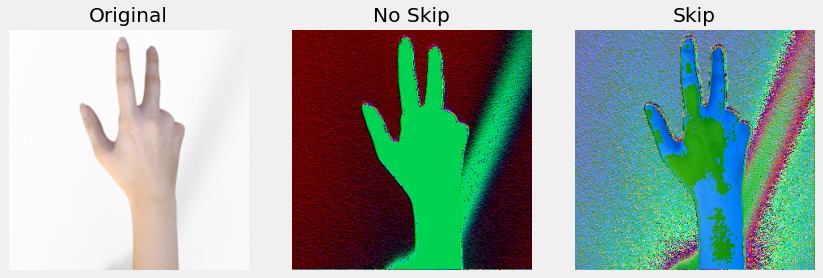

In [88]:
fig = compare_skip(scissors, noskip_image, skip_image)

On the one hand (that’s a good pun, c’mon!), **if there are no skip connections some
information may be lost**, like the different shades on the back of the hand. On the
other hand (sorry!), **skip connections may help to preserve that information.**

That’s the general idea behind the ResNet model. Of course, the whole
architecture is more complex than that, stacking many different residual blocks,
and adding some more bells and whistles to the mix. We’re not going into any more
details here, but the pre-trained models can be easily used for transfer learning,
just like we did with the AlexNet model.

# Putting It All Together

In this chapter we’ve gone through the necessary steps to use **transfer learning**
with pre-trained models for computer vision tasks: using **ImageNet statistics** for
pre-processing the inputs, **freezing** layers (or not), **replacing** the top layer, and
optionally **speeding up training by generating features** and training the top of the
**model independently.**

In [89]:
# ImageNet statistics
normalizer = Normalize(mean=[0.485, 0.456, 0.406],
                       std=[0.229, 0.224, 0.225])

composer = Compose([Resize(256),
                    CenterCrop(224),
                    ToTensor(),
                    normalizer])

train_data = ImageFolder(root='rps', transform=composer)
val_data = ImageFolder(root='rps-test-set', transform=composer)

# Builds a loader of each set
train_loader = DataLoader(train_data, batch_size=16, shuffle=True)
val_loader = DataLoader(val_data, batch_size=16)

This time, we’ll use the smallest version of the ResNet model (resnet18) and either
fine-tune it or use it as a feature extractor only.

## Fine-tuning

In [90]:
model = resnet18(pretrained=True)
torch.manual_seed(42)
model.fc = nn.Linear(512, 3)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\jobqu/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

There is **no freezing** since fine-tuning entails the training of all the weights, not only
those from the top layer.

In [92]:
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_model = optim.Adam(model.parameters(), lr=3e-4)

sbs_transfer = StepByStep(model, multi_loss_fn, optimizer_model)
sbs_transfer.set_loaders(train_loader, val_loader)

sbs_transfer.train(1)

Let’s see what the model can accomplish after training for a single epoch:

In [93]:
StepByStep.loader_apply(val_loader, sbs_transfer.correct)

tensor([[112, 124],
        [124, 124],
        [124, 124]])

Perfect score!

If we had frozen the layers in the model above, it would have been a case of
**feature extraction suitable for data augmentation** since we would be training the
top layer while attached to the rest of the model.

## Feature Extraction

In the model that follows, we’re **modifying the model** (replacing the top layer with
an identity layer) **to generate a dataset of features** first and then using it to train
the real top layer independently.

In [94]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = resnet18(pretrained=True).to(device)
model.fc = nn.Identity()
freeze_model(model)

In [95]:
train_preproc = preprocessed_dataset(model, train_loader)
val_preproc = preprocessed_dataset(model, val_loader)
train_preproc_loader = DataLoader(train_preproc, batch_size=16, shuffle=True)
val_preproc_loader = DataLoader(val_preproc, batch_size=16)

Once the dataset of features and its corresponding loaders are ready, we only need to **create a model corresponding to the top layer** and train it in the usual way:

In [99]:
torch.manual_seed(42)
top_model = nn.Sequential(nn.Linear(512, 3))
multi_loss_fn = nn.CrossEntropyLoss(reduction='mean')
optimizer_top = optim.Adam(top_model.parameters(), lr=3e-4)

In [100]:
sbs_top = StepByStep(top_model, multi_loss_fn, optimizer_top)
sbs_top.set_loaders(train_preproc_loader, val_preproc_loader)
sbs_top.train(10)

We surely can evaluate the model as it is using the same data loaders (containing
pre-processed features):

In [101]:
StepByStep.loader_apply(val_preproc_loader, sbs_top.correct)

tensor([[ 98, 124],
        [124, 124],
        [104, 124]])

But, if we want to try it out on the original dataset (containing the images), we
need to attach the top layer back:

In [102]:
model.fc = top_model
sbs_temp = StepByStep(model, None, None)

We can still create a separate instance of StepByStep for the full model to be able
to call its predict or correct methods (in this case, both loss function and
optimizers are set to None since we won’t be training the model anymore):

In [103]:
StepByStep.loader_apply(val_loader, sbs_temp.correct)

tensor([[ 98, 124],
        [124, 124],
        [104, 124]])

We got the same results, as expected.

## Recap

In this chapter, we’ve learned about the ImageNet Large Scale Visual Recognition
Challenge (ILSVRC) and the many model architectures developed to tackle it
(AlexNet, VGG, Inception, and ResNet). 

We used its pre-trained weights to perform transfer learning and either fine-tune or extract features for our own classification task instead. Moreover, we took a quick tour of the inner workings of many architectural elements built-in these models. This is what we’ve covered:

- learning about transfer learning (last pun in this chapter, I promise!)
- learning about ImageNet, ILSVRC, and the most popular architectures develop to tackle it 
- comparing the size, speed, and performance of these architectures
- loading the AlexNet model
- loading the model’s pre-trained weights
- freezing the layers of the model
- replacing the "top" layer of the model
- understanding the difference between fine-tuning and feature extraction
- using ImageNet statistics to pre-process the images
- generating a dataset of features using the frozen model
- training an independent model and attaching it to the original model
- understanding the role of auxiliary classifiers in very deep architectures
- building a loss function that handles auxiliary classifiers too
- training the top layer of an Inception V3 model
- using 1x1 convolutions as a dimension reduction layer
- building an inception module
- understanding what a batch normalization layer does
- discussing where to place the batch normalization layer, before or after an
activation function
- understanding the impact of mini-batch size on batch normalization statistics
- understanding the regularizer effect of batch normalization
- observing the effect of train and eval modes in batch normalization layers
- understanding what a residual/skip connection is
- understanding the effect of skip connections on the loss surface
- building a residual block
- fine-tuning and extracting features using a ResNet18 model

Congratulations! You have just finished the fourth and last chapter of Part II (not counting the "Extra" chapter)! You are now familiar with the most important tools
and techniques for handling computer vision problems. Although there will always
be a lot to learn since the field is very dynamic and new techniques are being
constantly developed, I believe that having a good grasp on how these building
blocks work should make it easier for you to further explore and keep learning on
your own.

In the next part, we’ll shift our focus to sequences and a whole new class of models:
recurrent neural networks and their variants.